# Importing

## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

from keras.models import Sequential
from keras.layers import Activation, Dense

from keras.optimizers import SGD, adam, adagrad, rmsprop


Using TensorFlow backend.


## importing own code

In [2]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

In [3]:
def trainNetwork(network, trainingData, validationSplit, numberOfEpochs=50, batchSize=32, verboseSetting=-1):
    """
    hjhgj
    
    network is the Keras network to be trained.
    trainingData is the data to be trained with. It is a tupple with the index zero being the input data and index one being the target/output value.
    validationData is the data used to do validation.  It is a tupple with the index zero being the input data and index one being the target/output value.
    numberOfEpochs is the number of epochs the model will train for default is 50.
    batchSize is the size of the batches during gradiant decent defaul is 32.
    verboseSettings are the verbose settings default is -1 (which does nothing), 0 results in plots and above that normal rules apply.
    """
    
    #print(np.shape(trainingData[0]))
    #print(np.shape(trainingData[0][0]))
    #print(np.shape(trainingData[1]))
    
    #print(trainingData[0])
    
    fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split = validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))
    
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    if verboseSetting>=0:
        
        maximumValue = max(max(history['loss']), max(history['val_loss']))
        minimumValue = math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax1.legend()
        ax1.set_xlim(1, numberOfEpochs)
        ax1.set_ylim(0, maximumValue)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss (training and validation) vs the number of epochs.')
        
        ax2.plot(history['loss'], history['val_loss'])
        ax2.set_xlim(0, maximumValue)
        ax2.set_ylim(0, maximumValue)
        ax2.set_xlabel('Training loss')
        ax2.set_ylabel('Validation loss')
        ax2.set_title('Validation loss vs training loss.')
        
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax3.legend()
        ax3.set_xlim(1, numberOfEpochs)
        ax3.set_yscale('log')
        ax3.set_ylim(minimumValue, maximumValue)
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Loss')
        ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
        
        ax4.plot(history['loss'], history['val_loss'])
        ax4.set_xscale('log')
        ax4.set_xlim(minimumValue, maximumValue)
        ax4.set_yscale('log')
        ax4.set_ylim(minimumValue, maximumValue)
        ax4.set_xlabel('Training loss')
        ax4.set_ylabel('Validation loss')
        ax4.set_title('Validation loss vs training loss (logarithmic).')
        
        math.pow(math.log(min(min(history['loss']), min(history['val_loss'])), 10), 10)
        
        plt.show()
        history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [4]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)

In [5]:
def makeDenseModel(inputSize, settings, learningRate, lossFunction='mape', useBias=False, kernalInitializer='he_uniform'):
    """
    
    """
    model = Sequential()
    model.add(Dense(settings[0], input_dim=inputSize, use_bias=useBias, kernel_initializer=kernalInitializer))
    model.add(Activation('relu'))
    
    for i in range(1, len(settings)):
        model.add(Dense(settings[i], use_bias=useBias, kernel_initializer=kernalInitializer))
        model.add(Activation('relu'))
    
    model.add(Dense(1, use_bias=useBias, kernel_initializer=kernalInitializer))
    model.add(Activation('linear'))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model


In [6]:
def makeNetwork(inputSize, settings, learningRate, lossFunction='mse', kernalInitializer='he_uniform'):
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], kernel_initializer=kernalInitializer))
    model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        if setting[0]=='Dense':# 1 is amount of nodes, 2 is kind of activation, 3 is bias
            model.add(Dense(setting[1], use_bias=setting[3], kernel_initializer=kernalInitializer))
            model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model

# Getting data

In [7]:
filename = 'combinedDataPrepared'#'combinedDataPrepared'
orderOfMatrix = False# Make a list if you want to do the calculations yourself and make a other type of you want to import it

if (type(orderOfMatrix) == list):
    dataRaw = pd.read_json(filename + '.json', orient='columns')
    dataRaw['particleCoordinates'] = dataRaw['particleCoordinates'].apply(np.array)
    data = prepareDatabseForMachineLearningMultiprocessing(dataRaw, orderOfMatrix, filename + 'Prepared', amountOfCores)
    #data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
else:
    data = pd.read_json(filename + '.json', orient='columns')
    data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
    #data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
    #data['eigenvalues'] = data['eigenvalues'].apply(list)

In [8]:
#data.head()

In [9]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,230000.000000,230000.000000,230000.0,2.300000e+05
mean,114999.500000,25.487190,4.0,6.070610e+13
std,66395.425294,14.131367,0.0,2.831373e+16
min,0.000000,1.000061,4.0,-5.304560e-02
25%,57499.750000,13.237067,4.0,-2.850000e-08
50%,114999.500000,25.526970,4.0,1.575000e-07
75%,172499.250000,37.695345,4.0,4.950171e-04
max,229999.000000,49.999449,4.0,1.357338e+19


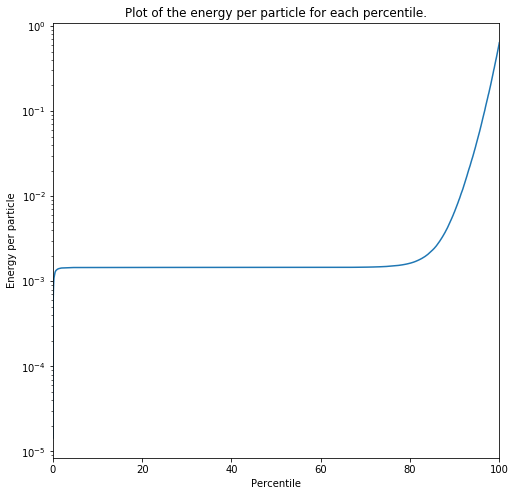

In [10]:
qLow = data['potentialEnergy'].quantile(0.001)
qHi  = data['potentialEnergy'].quantile(0.90)
dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

data = dataFiltered

In [11]:
#data.head()

In [12]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,206770.000000,206770.000000,206770.0,2.067700e+05
mean,114948.662369,27.614281,4.0,1.132964e-02
std,66373.605290,13.065884,0.0,5.710787e-02
min,0.000000,2.013963,4.0,-1.439068e-03
25%,57493.250000,16.555071,4.0,-4.020000e-08
50%,114949.500000,27.861409,4.0,9.800000e-09
75%,172413.750000,38.869106,4.0,4.189617e-05
max,229999.000000,49.999449,4.0,6.335761e-01


In [13]:
#data['potentialEnergy'] = data['potentialEnergy']-min(data['potentialEnergy'])

trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])
    targetData.append(trainingData['potentialEnergy'][i])

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]


# Machine learning

## Model 1

In [14]:
inputSize = 8
settings = [['Dense', 64, 'softplus', False], ['Dense', 64, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4096      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 64        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 4,672
Trainable params: 4,672
Non-trainable params: 0
____________________________________________________

In [ ]:
trainNetwork(model, trainingInput, 0.2, numberOfEpochs=100, batchSize=32, verboseSetting=1)
print()

Train on 132332 samples, validate on 33084 samples
Epoch 1/100
132332/132332 [==============================] - 14s 102us/step - loss: 0.0329 - val_loss: 9.6011e-04
Epoch 2/100
132332/132332 [==============================] - 12s 93us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/100
132332/132332 [==============================] - 12s 93us/step - loss: 0.0015 - val_loss: 0.0054
Epoch 4/100
132332/132332 [==============================] - 13s 95us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/100
132332/132332 [==============================] - 12s 93us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/100
132332/132332 [==============================] - 12s 93us/step - loss: 0.0011 - val_loss: 4.4186e-04
Epoch 7/100
132332/132332 [==============================] - 12s 94us/step - loss: 9.8498e-04 - val_loss: 0.0057
Epoch 8/100
132332/132332 [==============================] - 12s 92us/step - loss: 8.3637e-04 - val_loss: 6.3220e-04
Epoch 9/100
132332/132332 [=============================

In [ ]:
for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

## Model 2

In [ ]:
inputSize = 8
settings = [['Dense', 64, 'softplus', False], ['Dense', 64, 'softplus', True], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.2, numberOfEpochs=100, batchSize=32, verboseSetting=1)
print()

In [ ]:
for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

## Model 3

In [ ]:
inputSize = 8
settings = [['Dense', 64, 'softplus', False], ['Dense', 64, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.2, numberOfEpochs=100, batchSize=32, verboseSetting=1)
print()

In [ ]:
for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

## Model 4

In [ ]:
inputSize = 8
settings = [['Dense', 64, 'softplus', True], ['Dense', 64, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.2, numberOfEpochs=100, batchSize=32, verboseSetting=1)
print()

In [ ]:
for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])